<a href="https://colab.research.google.com/github/yogitaaax22/eeg_website/blob/main/notebooks/google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Core
import numpy as np
import pandas as pd
import os
import zipfile

# EEG / Signal processing
from scipy.io import loadmat
from scipy.signal import welch

# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("All libraries imported successfully")


All libraries imported successfully


In [24]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
#Unzip the file
import zipfile

zip_path = '/content/drive/MyDrive/EEG_480_signals.zip'
extract_dir = '/content/eeg_files'

# Extract only once
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("All files extracted to:", extract_dir)


All files extracted to: /content/eeg_files


In [26]:
import os

DATA_PATH = "eeg_files/raw_data"

mat_files = []
for file in os.listdir(DATA_PATH):
    if file.endswith(".mat"):
        mat_files.append(os.path.join(DATA_PATH, file))

print("Total .mat files found:", len(mat_files))
print("First 5 files:", mat_files[:5])





Total .mat files found: 480
First 5 files: ['eeg_files/raw_data/Arithmetic_sub_6_trial2.mat', 'eeg_files/raw_data/Arithmetic_sub_6_trial3.mat', 'eeg_files/raw_data/Stroop_sub_22_trial3.mat', 'eeg_files/raw_data/Relax_sub_13_trial2.mat', 'eeg_files/raw_data/Arithmetic_sub_27_trial3.mat']


In [27]:
from scipy.io import loadmat

sample = loadmat(mat_files[0])
print(sample.keys())


dict_keys(['__header__', '__version__', '__globals__', 'Data'])


In [28]:
EEG_KEY = 'Data'

eeg = sample[EEG_KEY]
print("Original EEG shape:", eeg.shape)


Original EEG shape: (32, 3200)


Single-channel EEG shape: (3200,)


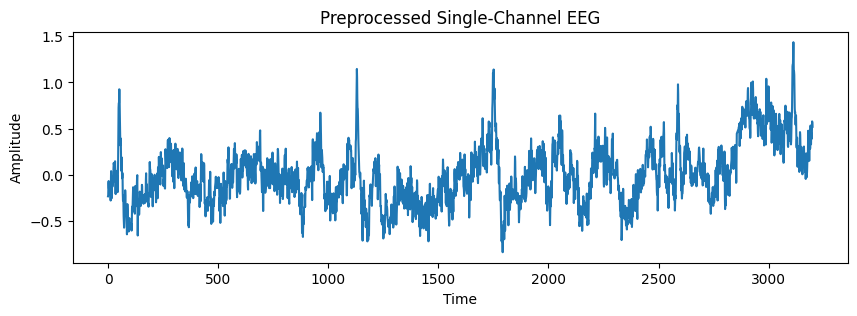

In [29]:
# Ensure shape is (time, channels)
if eeg.shape[0] < eeg.shape[1]:
    eeg = eeg.T

# Normalize
eeg = (eeg - np.mean(eeg)) / np.std(eeg)

# Convert to single channel
eeg_1ch = np.mean(eeg, axis=1)

print("Single-channel EEG shape:", eeg_1ch.shape)

# Plot to verify
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(eeg_1ch)
plt.title("Preprocessed Single-Channel EEG")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


In [30]:
def extract_band_power(signal, fs=128):
    freqs, psd = welch(signal, fs=fs, nperseg=fs*2)
    bands = {'low': (0.5, 8), 'alpha': (8, 13), 'beta': (13, 30)}

    powers = []
    for band in bands.values():
        idx = (freqs >= band[0]) & (freqs <= band[1])
        powers.append(np.mean(psd[idx]))

    total = sum(powers) + 1e-6
    return [p / total for p in powers]

In [31]:
from scipy.stats import skew, kurtosis, mstats

X = []
y = []

for file_path in mat_files:
    mat = loadmat(file_path)
    eeg = mat['Data']
    if eeg.shape[0] < eeg.shape[1]: eeg = eeg.T


    # winsorizing- This keeps 95% of the data but pulls in the extreme 'noise' spikes
    eeg = mstats.winsorize(eeg, limits=[0.05, 0.05], axis=0)

    eeg = (eeg - np.mean(eeg, axis=0)) / (np.std(eeg, axis=0) + 1e-6)

    all_channel_features = []
    for ch in range(eeg.shape[1]):
        sig = eeg[:, ch]
        rel_p = extract_band_power(sig)
        all_channel_features.append(rel_p + [skew(sig), kurtosis(sig)])

    ch_feats = np.array(all_channel_features)

   #only using frontal and back average to keep it simpler
    front = ch_feats[:16].mean(axis=0)
    back = ch_feats[16:].mean(axis=0)

    X.append(np.concatenate([front, back])) # 10 features total
    y.append(0 if 'relax' in file_path.lower() else 1)

X = np.array(X)
y = np.array(y)

In [32]:
X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

Feature matrix shape: (480, 10)
Labels shape: (480,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# REAL BASELINE; mean of all Relax samples in training set
baseline = np.mean(X_train[y_train == 0], axis=0)


print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 384
Testing samples: 96


In [45]:
from xgboost import XGBClassifier

# We reset the threshold logic and let the model handle weights internally
model = XGBClassifier(
    n_estimators=100,       # Fewer trees to prevent overfitting
    max_depth=3,            # Very shallow trees
    learning_rate=0.05,
    scale_pos_weight=3,      # Exactly matches our 3:1 data ratio
    subsample=0.8,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train)
stress_levels = model.predict(X_test)
print("Golden XGBoost Trained")

Golden XGBoost Trained


In [60]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Getting raw probabilities instead of hard labels
probs = model.predict_proba(X_test)[:, 1]

threshold = 0.6
y_pred = (probs > threshold).astype(int)

print(f"New Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

New Accuracy: 0.8229166666666666
              precision    recall  f1-score   support

           0       0.89      0.33      0.48        24
           1       0.82      0.99      0.89        72

    accuracy                           0.82        96
   macro avg       0.85      0.66      0.69        96
weighted avg       0.83      0.82      0.79        96



In [47]:
import pickle

# Save trained model
with open("stress_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save baseline (mean of relax samples in training set)
baseline = X_train[y_train == 0].mean(axis=0)
with open("baseline.pkl", "wb") as f:
    pickle.dump(baseline, f)

print("Model and baseline saved successfully!")


Model and baseline saved successfully!


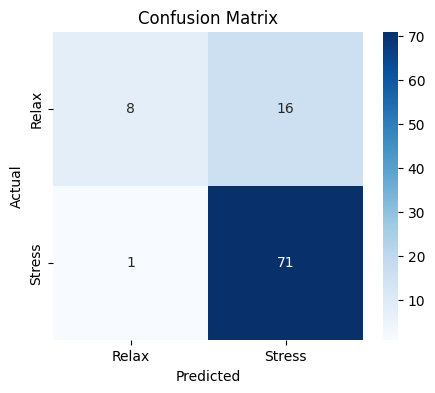

In [48]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Relax', 'Stress'],
            yticklabels=['Relax', 'Stress'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


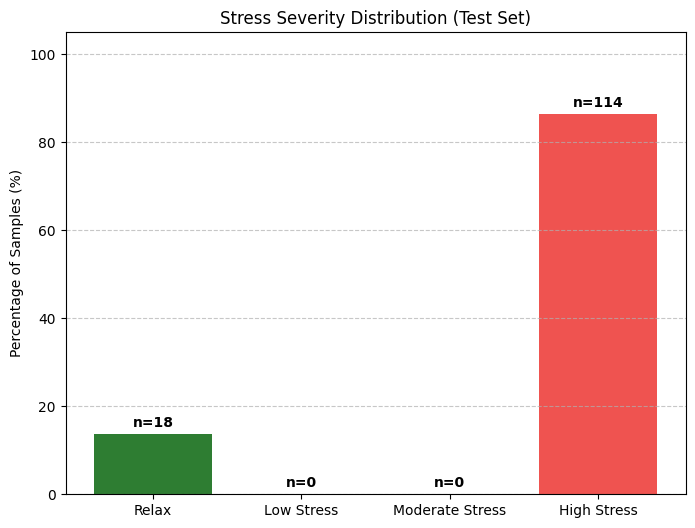

In [59]:
import matplotlib.pyplot as plt
from collections import Counter

# 1. First, check if we actually have results to plot
if 'stress_levels' not in locals() or len(stress_levels) == 0:
    print("Error: No stress levels found. Please run the Model Prediction block first!")
else:
    counts = Counter(stress_levels)
    total = sum(counts.values())

    # 2. Define labels and colors
    # Note: Using 0, 1, 2, 3 as keys because the model outputs numbers
    labels = ["Relax", "Low Stress", "Moderate Stress", "High Stress"]
    colors = ["#2e7d32", "#9ccc65", "#ffa726", "#ef5350"] # Clean Professional Colors

    # 3. Calculate percentages safely
    percentages = [(counts.get(i, 0) / total) * 100 for i in range(4)]
    sample_counts = [counts.get(i, 0) for i in range(4)]

    # 4. Create the Plot
    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, percentages, color=colors)

    plt.ylabel("Percentage of Samples (%)")
    plt.title("Stress Severity Distribution (Test Set)")
    plt.ylim(0, 105) # Give a little extra room for the text labels

    # 5. Annotate bars with sample counts (e.g., n=10)
    for bar, count in zip(bars, sample_counts):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 1,
            f"n={count}",
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [52]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("CV Accuracy:", scores.mean(), "±", scores.std())


CV Accuracy: 0.7416666666666666 ± 0.01530931089239486


In [53]:
!ls


baseline.pkl  drive  eeg_files	sample_data  stress_model.pkl


In [57]:
from google.colab import files

files.download('stress_model.pkl')
files.download('baseline.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>